# Warranty Claims

This notebook goes though each of the steps in <b>Chapter 5.1 Setup Overview</b> for the Warranty Claims data set.

With this being a much larger data set, some parts of the code can take a while to run.

The main areas this notebook covers are:

- Building 5 machine learning models with the data set.
- View their performances with evaluation metrics.
- Apply feature importance for each model.
- Explore the top 3 most important features to see how a model reacts to changes to the given features.
- Build a visualisation tool to view and interact with each model's predictions.

<b>Student Name: </b> William King 

<b>Student Number: </b> 950178

<b>Last Updated: </b> July 7th 2020

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from kmeans_predict import predict # Seperate python file that has functions to help with predictions for KMeans.
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import eli5
from eli5.sklearn import PermutationImportance 
from eli5.permutation_importance import get_score_importances
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
import altair as alt
from altair import datum

Using TensorFlow backend.
c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## Import the Data Set

This involves preparing the data for training. 

The train / test split will be applied for the supervised models.

Some attributes are removed for training because they aren't essential to the prediction process:

- Unnamed: 0
- Region
- State
- Area
- Product Category (essentially the same as product type because there are 2 products in the data set)
- Fraud (Labels)

A unique ID is set for each data instance so that the model's predictions can be allocated to their respective data instance. This helps with the supervised algorithms to be displayed with the unsupervised algorithms in the visualisation tool due to the train / test split.

In [2]:
warranty_df = pd.read_csv('Datasets/warranty_claims/train.csv')
anomaly_points_df = warranty_df['Fraud']
anomaly_points = anomaly_points_df.values.reshape(-1, 1)

# Shows No. points that are normal and fraudulent.
# 0 = normal, 1 = Fraud.
print(warranty_df.pivot_table(index = ['Fraud'], aggfunc = 'size')) 

# Check No. of NaN values for each attribute.
print(warranty_df.isna().sum())

# Fill NaN values with 0.
warranty_df.fillna(0, inplace = True)
print(warranty_df.shape)

# Convert necessary categorical data into numerical data.
warranty_df['Consumer_profile'] = pd.Categorical(warranty_df['Consumer_profile'])
warranty_df['Consumer_profile_code'] = warranty_df['Consumer_profile'].cat.codes

warranty_df['Product_type'] = pd.Categorical(warranty_df['Product_type'])
warranty_df['Product_type_code'] = warranty_df['Product_type'].cat.codes

warranty_df['Purchased_from'] = pd.Categorical(warranty_df['Purchased_from'])
warranty_df['Purchased_from_code'] = warranty_df['Purchased_from'].cat.codes

warranty_df['Purpose'] = pd.Categorical(warranty_df['Purpose'])
warranty_df['Purpose_code'] = warranty_df['Purpose'].cat.codes

# Add unique IDs for each data record. For visualisation purposes and in aid for test data.
warranty_df['Unique_ID'] = None
for i in range(warranty_df.shape[0]):
    warranty_df['Unique_ID'][i] = "ID" + str(i)
    if warranty_df['Purpose'][i] == 'claim': # Also change 'claim' to 'Claim'.
        warranty_df['Purpose'][i] = 'Claim'
#print("UniqueID TYPE:", warranty_df['Unique_ID'].dtype)
#print(warranty_df.head)
#print(warranty_df.columns)

# Set index to Unique_ID.
warranty_df = warranty_df.set_index('Unique_ID')
#print(warranty_df.loc['ID9'])

# Select the columns to be used for prediction.
irrelavent_columns = ['Unnamed: 0', 'Fraud', 'Region', 'State', 'Area', 'City', 'Product_category']
feature_columns = [i for i in warranty_df.columns if (warranty_df[i].dtype in [object, np.int64, np.int8, np.float64]) 
                   and (i not in irrelavent_columns)]
data_df = warranty_df[feature_columns] # For unsupervised algorithms.
data_df = data_df.copy().reset_index()
#print(data_df.shape)

# Apply train / test split on the data. Used for supervised algorithms. Currently at 80 / 20 split.
train_data, test_data, train_labels, test_labels = train_test_split(data_df, anomaly_points_df, 
                                                                    test_size = 0.2, random_state = 1)

# Create copy for supervised algorithms (visualisation tool purposes)
# then remove Unique_ID for training.
test_data_with_ID = test_data.copy().reset_index()
#print(data_df.shape)
del data_df['Unique_ID']
del train_data['Unique_ID']
del test_data['Unique_ID']
#print(data_df.shape)
#print(train_data.columns)

Fraud
0    7675
1     666
dtype: int64
Unnamed: 0            0
Region                0
State                 0
Area                  0
City                  0
Consumer_profile      0
Product_category      0
Product_type          0
AC_1001_Issue         0
AC_1002_Issue         0
AC_1003_Issue         0
TV_2001_Issue         0
TV_2002_Issue         0
TV_2003_Issue         0
Claim_Value         240
Service_Centre        0
Product_Age           0
Purchased_from        0
Call_details          0
Purpose               0
Fraud                 0
dtype: int64
(8341, 21)


## Adjust Data Set before training

The data is normalised before training.

In [3]:
#Normalise the data in dataframe (Unsupervised).
standardised_data = StandardScaler().fit_transform(data_df)

# Normalise the data based on the training data (Supervised).
normaliser = StandardScaler().fit(train_data)
train_data = normaliser.transform(train_data)
test_data = normaliser.transform(test_data)

#Seperate the normalised data from the labels (Unsupervised).
x = standardised_data
y = anomaly_points

# PCA Reducted Data (for axis option in visualisation tool).
pca_supervised = PCA(n_components = 2).fit_transform(test_data)
pca_unsupervised = PCA(n_components = 2).fit_transform(x)

## Train Unsupervised Algorithms

- K-Means Clustering
- K-Nearest Neighbours
- AutoEncoder - Can take a long time to train.

In [4]:
#----------K-Means Clustering----------
kmeans_threshold = 0.11
kmeans_model = KMeans(8) # 8 is optimum (with normalised data).
kmeans_model.fit(x)
kmeans_pred = predict(kmeans_model, x, contamination = kmeans_threshold)

#----------K-Nearest Neighbours----------
knn_threshold = 0.08
knn_model = KNN(n_neighbors = 19, contamination = knn_threshold) # 19 is optimum (with normalised data).
knn_model.fit(x)
knn_pred = knn_model.predict(x)

#----------AutoEncoder----------
ae_threshold = 0.1
ae_model = AutoEncoder(hidden_neurons = [14, 7, 4, 2, 4, 7, 14],
                                epochs = 100,
                                verbose = 0,
                                contamination = ae_threshold)
ae_model.fit(x)
ae_pred = ae_model.labels_

## Supervised Algorithms

- Random Forest
- Neural Network (MLP)

In [5]:
#----------Random Forest----------
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators = 100)
rf_model.fit(train_data, train_labels)
rf_pred = rf_model.predict(test_data)


#----------Neural Network (MLP)----------
from sklearn.neural_network import MLPClassifier
nn_model = MLPClassifier(hidden_layer_sizes=(100, ), max_iter = 1000).fit(train_data, train_labels)
nn_pred= nn_model.predict(test_data)

## Evaluation Metrics

The positive class is fraudulent because this is what we're looking for.

The following metrics used are:

- Accuracy
- Precision
- Recall
- F1 Score
- Confusion Matrix

In [42]:
#Unsupervised Techniques
print("----------Unsupervised Algorithms----------")
print("K-Means Clustering Performance in %:")
print("Accuracy:", accuracy_score(y, kmeans_pred) * 100)
print("Precision:", precision_score(y, kmeans_pred) * 100)
print("Recall:", recall_score(y, kmeans_pred) * 100)
print("F1 Score:", f1_score(y, kmeans_pred) * 100)
print("Confusion Matrix: ")
print(confusion_matrix(y, kmeans_pred))
print()
print("K-Nearest Neighbours Performance in %:")
print("Accuracy:", accuracy_score(y, knn_pred) * 100)
print("Precision:", precision_score(y, knn_pred) * 100)
print("Recall:", recall_score(y, knn_pred) * 100)
print("F1 Score:", f1_score(y, knn_pred) * 100)
print("Confusion Matrix: ")
print(confusion_matrix(y, knn_pred))
print()
print("AutoEncoder Performance in %:")
print("Accuracy:", accuracy_score(y, ae_pred) * 100)
print("Precision:", precision_score(y, ae_pred) * 100)
print("Recall:", recall_score(y, ae_pred) * 100)
print("F1 Score:", f1_score(y, ae_pred) * 100)
print("Confusion Matrix: ")
print(confusion_matrix(y, ae_pred))
print()

#Supervised Techniques
print("----------Supervised Algorithms----------")
print("Random Forest Performance in %:")
print("Accuracy:", accuracy_score(test_labels, rf_pred) * 100)
print("Precision:", precision_score(test_labels, rf_pred) * 100)
print("Recall:", recall_score(test_labels, rf_pred) * 100)
print("F1 Score:", f1_score(test_labels, rf_pred) * 100)
print("Confusion Matrix: ")
print(confusion_matrix(test_labels, rf_pred))
print()
print("Neural Network Performance in %:")
print("Accuracy:", accuracy_score(test_labels, nn_pred) * 100)
print("Precision:", precision_score(test_labels, nn_pred) * 100)
print("Recall:", recall_score(test_labels, nn_pred) * 100)
print("F1 Score:", f1_score(test_labels, nn_pred) * 100)
print("Confusion Matrix: ")
print(confusion_matrix(test_labels, nn_pred))

----------Unsupervised Algorithms----------
K-Means Clustering Performance in %:
Accuracy: 85.46936818127323
Precision: 20.70815450643777
Recall: 28.97897897897898
F1 Score: 24.155193992490613
Confusion Matrix: 
[[6936  739]
 [ 473  193]]

K-Nearest Neighbours Performance in %:
Accuracy: 86.38052991248053
Precision: 13.509316770186336
Recall: 13.063063063063062
F1 Score: 13.282442748091604
Confusion Matrix: 
[[7118  557]
 [ 579   87]]

AutoEncoder Performance in %:
Accuracy: 83.87483515166048
Precision: 8.034610630407911
Recall: 9.75975975975976
F1 Score: 8.8135593220339
Confusion Matrix: 
[[6931  744]
 [ 601   65]]

----------Supervised Algorithms----------
Random Forest Performance in %:
Accuracy: 97.36369083283404
Precision: 91.30434782608695
Recall: 75.53956834532374
F1 Score: 82.67716535433071
Confusion Matrix: 
[[1520   10]
 [  34  105]]

Neural Network Performance in %:
Accuracy: 97.36369083283404
Precision: 85.71428571428571
Recall: 82.01438848920863
F1 Score: 83.82352941176471

## Permutation Importance 

Feature importance is explored for each model.

It shows the features that impacted the prediction stage the most by calculating the model's mean decrease in performance when a feature is not present.

In this case, the feature is replaced by random noise so that it will no longer hold any useful information.

### kMeans

In [43]:
# Score function to determine performance (accuracy is used).
def kmeans_score(X, y):
    y_pred = predict(kmeans_model, X, contamination = kmeans_threshold)
    return accuracy_score(y, y_pred)

# Calculate mean accuracy decrease.
base_score, score_decreases = get_score_importances(kmeans_score, x, y)
feature_importances = np.mean(score_decreases, axis = 0)

# Label each score to their respective features, then sort them in descending order.
feature_importance_dict = {}
for i, feature_name in enumerate(data_df.columns):
    feature_importance_dict[feature_name] = feature_importances[i]
perm_df = pd.DataFrame(sorted(feature_importance_dict.items(), key = lambda x: x[1], reverse = True))
perm_df.columns = ['Feature', 'Weight']
print(perm_df)

                  Feature    Weight
0             Claim_Value  0.027575
1           TV_2003_Issue  0.022587
2           AC_1003_Issue  0.021580
3           TV_2001_Issue  0.021508
4       Product_type_code  0.020933
5           AC_1001_Issue  0.017983
6             Product_Age  0.016952
7           TV_2002_Issue  0.016904
8           AC_1002_Issue  0.015250
9            Call_details  0.011246
10           Purpose_code  0.009663
11    Purchased_from_code  0.005131
12         Service_Centre  0.003765
13  Consumer_profile_code  0.001942


### kNearest Neighbours 

In [44]:
# Score function to determine performance (accuracy is used).
def knn_score(X, y):
    y_pred = knn_model.predict(X)
    return accuracy_score(y, y_pred)

# Calculate mean accuracy decrease.
base_score, score_decreases = get_score_importances(knn_score, x, y)
feature_importances = np.mean(score_decreases, axis = 0)

# Label each score to their respective features, then sort them in descending order.
feature_importance_dict = {}
for i, feature_name in enumerate(data_df.columns):
    feature_importance_dict[feature_name] = feature_importances[i]
perm_df = pd.DataFrame(sorted(feature_importance_dict.items(), key = lambda x: x[1], reverse = True))
perm_df.columns = ['Feature', 'Weight']
print(perm_df)

                  Feature    Weight
0       Product_type_code  0.295864
1   Consumer_profile_code  0.184246
2            Call_details  0.175710
3           AC_1003_Issue  0.141398
4             Product_Age  0.108932
5     Purchased_from_code  0.094737
6           AC_1001_Issue  0.072701
7           TV_2002_Issue  0.069968
8           AC_1002_Issue  0.069416
9             Claim_Value  0.068289
10         Service_Centre  0.068097
11           Purpose_code  0.048723
12          TV_2001_Issue  0.047452
13          TV_2003_Issue  0.037813


### Autoencoder 

In [45]:
# Score function to determine performance (accuracy is used).
def ae_score(X, y):
    y_pred = ae_model.predict(X)
    return accuracy_score(y, y_pred)

# Calculate mean accuracy decrease.
base_score, score_decreases = get_score_importances(ae_score, x, y)
feature_importances = np.mean(score_decreases, axis = 0)

# Label each score to their respective features, then sort them in descending order.
feature_importance_dict = {}
for i, feature_name in enumerate(data_df.columns):
    feature_importance_dict[feature_name] = feature_importances[i]
perm_df = pd.DataFrame(sorted(feature_importance_dict.items(), key = lambda x: x[1], reverse = True))
perm_df.columns = ['Feature', 'Weight']
print(perm_df)

                  Feature    Weight
0             Claim_Value  0.019038
1           TV_2001_Issue  0.006858
2           TV_2003_Issue  0.006858
3     Purchased_from_code  0.000599
4       Product_type_code  0.000000
5   Consumer_profile_code -0.000072
6           AC_1001_Issue -0.000456
7           TV_2002_Issue -0.000719
8          Service_Centre -0.002518
9           AC_1002_Issue -0.003405
10           Purpose_code -0.004484
11            Product_Age -0.004891
12          AC_1003_Issue -0.005659
13           Call_details -0.012229


### Random Forest 

In [46]:
rf_perm = PermutationImportance(rf_model, random_state = 1).fit(test_data, test_labels)
eli5.show_weights(rf_perm, top = data_df.shape[1], feature_names = data_df.columns.tolist())

### Neural Network 

In [47]:
nn_perm = PermutationImportance(nn_model, random_state = 1).fit(test_data, test_labels)
eli5.show_weights(nn_perm, top = data_df.shape[1], feature_names = data_df.columns.tolist())

## Partial Dependence Plots (PDP) 

This explores how a model responds to changes to a given feature and shows the direction it's influencing.

These will be applied to the top 3 most impactful features for each model.

### kMeans 

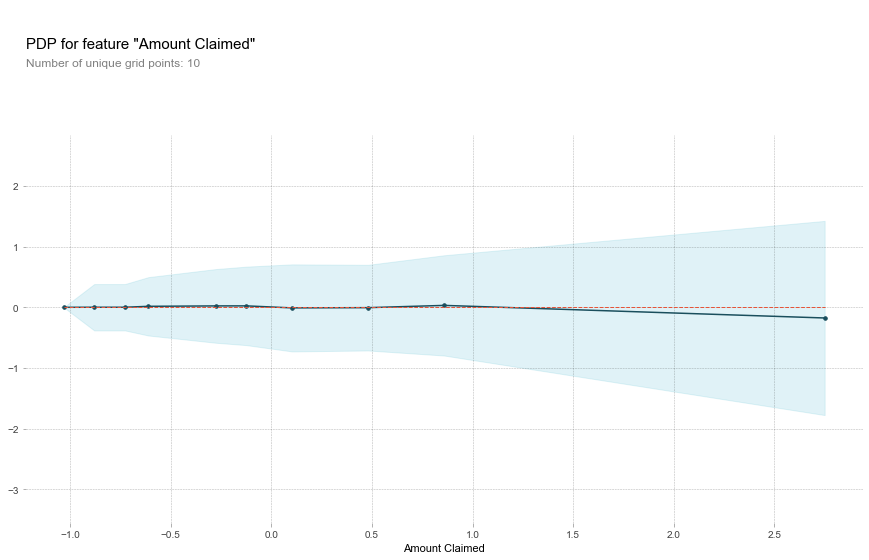

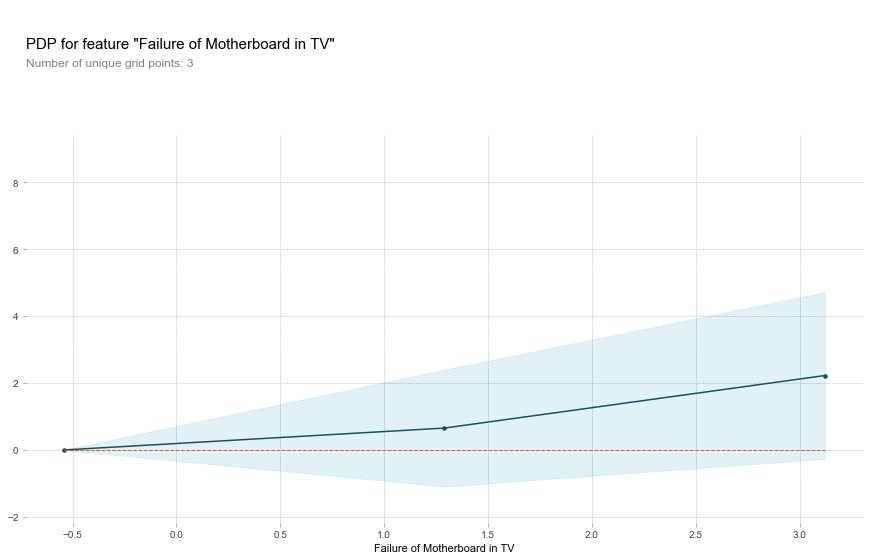

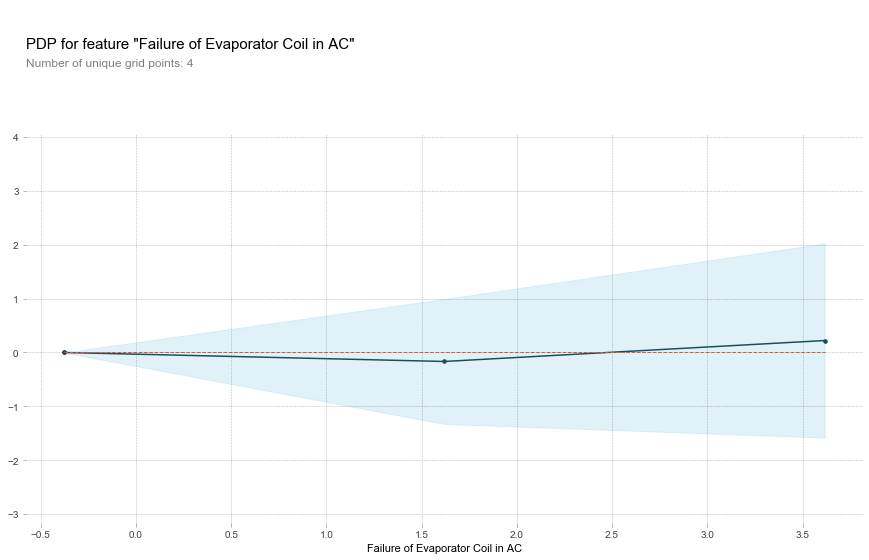

In [58]:
# Create a new dataframe that holds the normalised data, each model was trained using normalised data.
# It contains the features used for training.
df_columns = data_df.columns
new_df = pd.DataFrame(x)
new_df.columns = df_columns

# Create plots for the top 3 features.
pdp_claim_value = pdp.pdp_isolate(model = kmeans_model, dataset = new_df, model_features = data_df.columns, 
                                    feature = 'Claim_Value')

pdp_tv_2003_issue = pdp.pdp_isolate(model = kmeans_model, dataset = new_df, model_features = data_df.columns, 
                                    feature = 'TV_2003_Issue')

pdp_ac_1003_issue = pdp.pdp_isolate(model = kmeans_model, dataset = new_df, model_features = data_df.columns, 
                                    feature = 'AC_1003_Issue')

# plot them.
pdp.pdp_plot(pdp_claim_value, 'Amount Claimed')
pdp.pdp_plot(pdp_tv_2003_issue, 'Failure of Motherboard in TV')
pdp.pdp_plot(pdp_ac_1003_issue, 'Failure of Evaporator Coil in AC')
plt.show()

### kNearest Neighbours

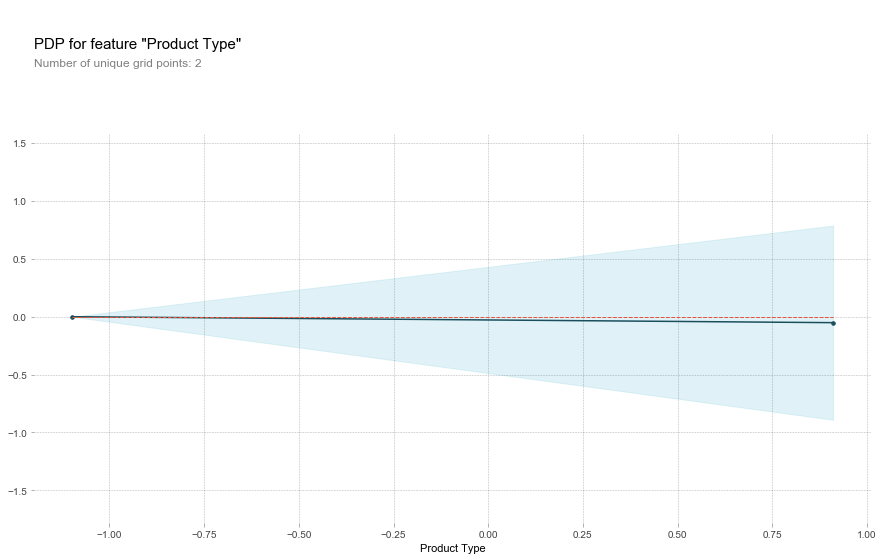

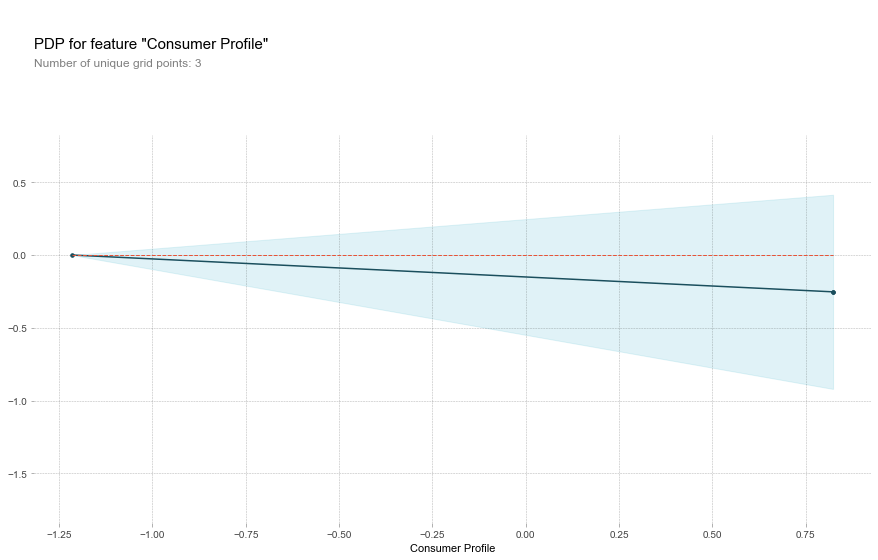

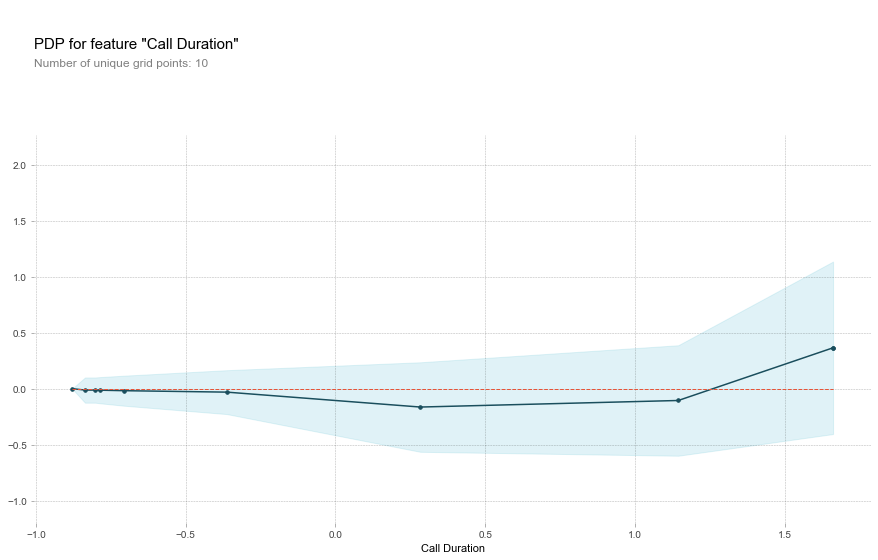

In [63]:
# Create plots for the top 3 features.
pdp_product_type = pdp.pdp_isolate(model = knn_model, dataset = new_df, model_features = data_df.columns, 
                                    feature = 'Product_type_code')

pdp_consumer_prof = pdp.pdp_isolate(model = knn_model, dataset = new_df, model_features = data_df.columns, 
                                    feature = 'Consumer_profile_code')


pdp_call_details = pdp.pdp_isolate(model = knn_model, dataset = new_df, model_features = data_df.columns, 
                                    feature = 'Call_details')

# plot them.
pdp.pdp_plot(pdp_product_type, 'Product Type')
pdp.pdp_plot(pdp_consumer_prof, 'Consumer Profile')
pdp.pdp_plot(pdp_call_details, 'Call Duration')
plt.show()

### AutoEncoder

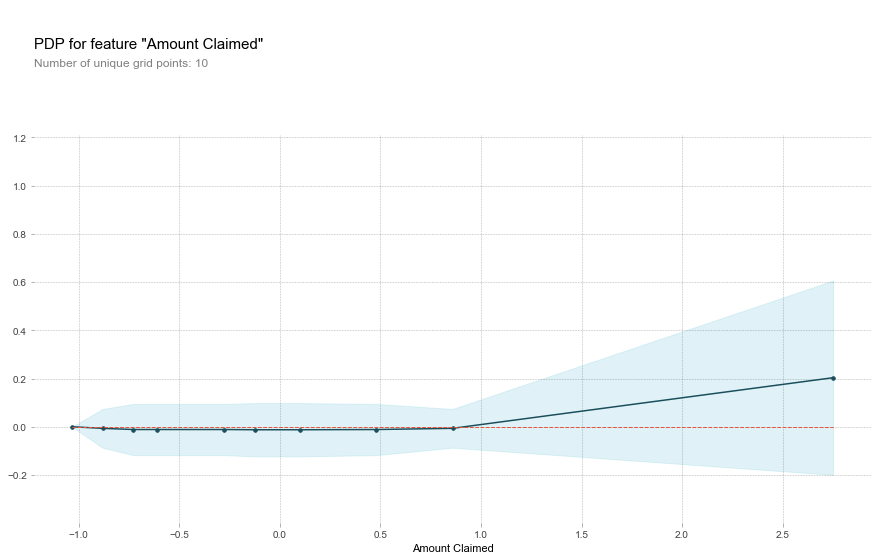

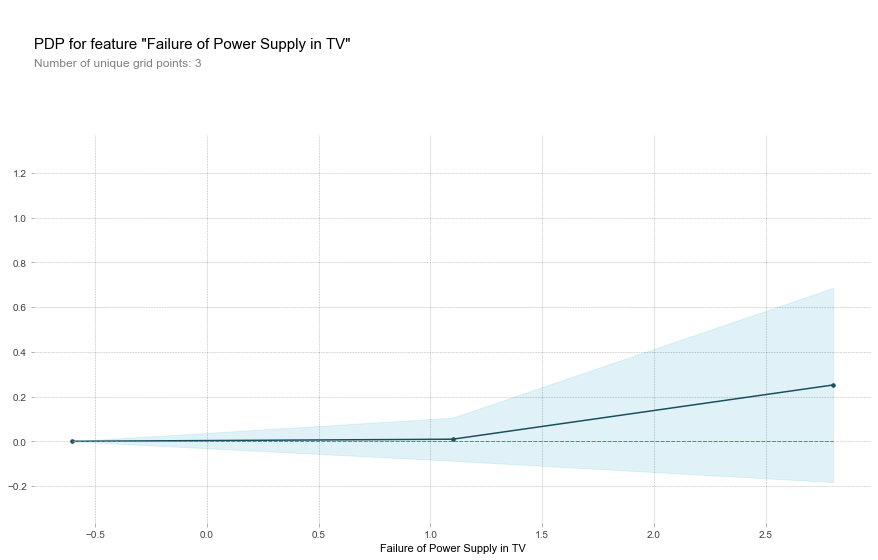

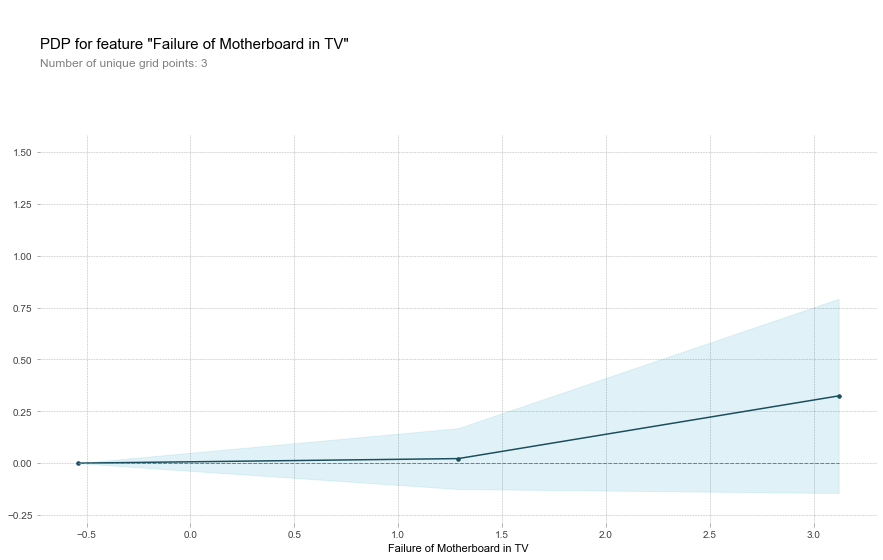

In [64]:
# Create plots for the top 3 features.
pdp_claim_value = pdp.pdp_isolate(model = ae_model, dataset = new_df, model_features = data_df.columns, 
                                    feature = 'Claim_Value')

pdp_tv_2001_issue = pdp.pdp_isolate(model = ae_model, dataset = new_df, model_features = data_df.columns, 
                                    feature = 'TV_2001_Issue')

pdp_tv_2003_issue = pdp.pdp_isolate(model = ae_model, dataset = new_df, model_features = data_df.columns, 
                                    feature = 'TV_2003_Issue')

# plot them.
pdp.pdp_plot(pdp_claim_value, 'Amount Claimed')
pdp.pdp_plot(pdp_tv_2001_issue, 'Failure of Power Supply in TV')
pdp.pdp_plot(pdp_tv_2003_issue, 'Failure of Motherboard in TV')
plt.show()

### Random Forest

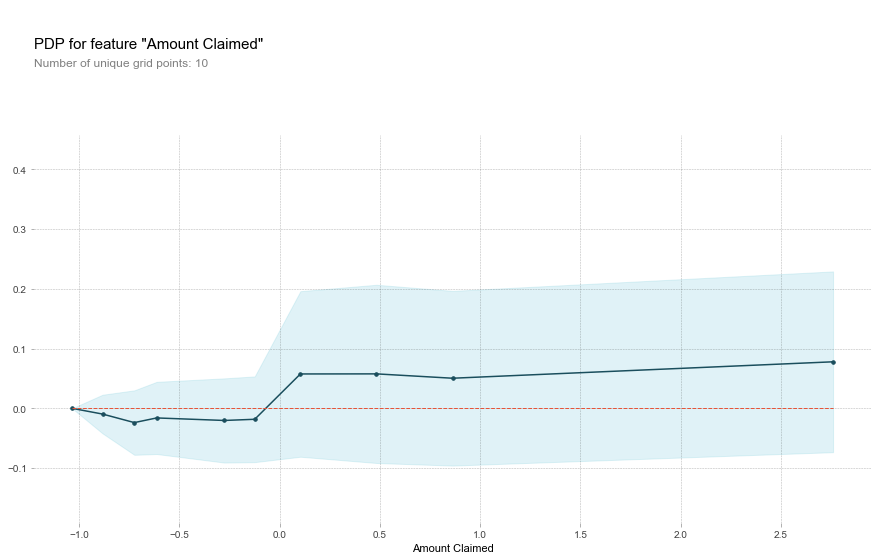

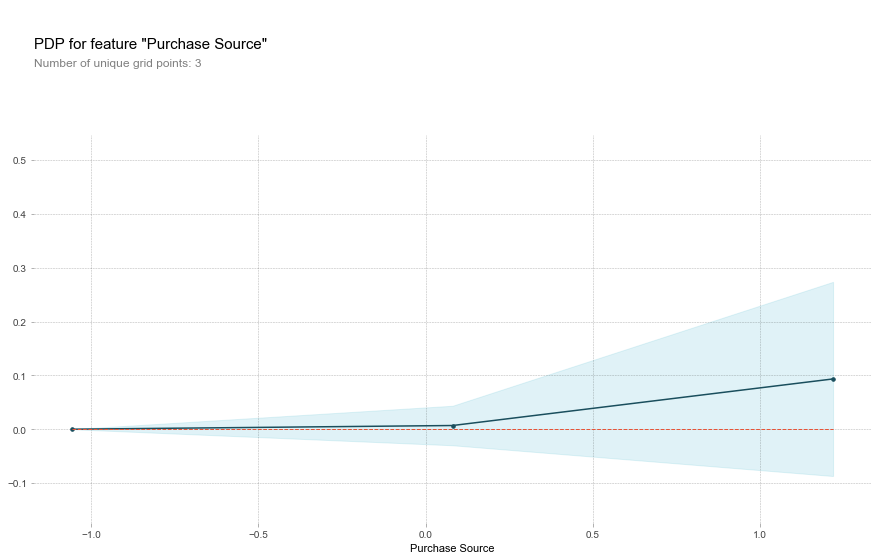

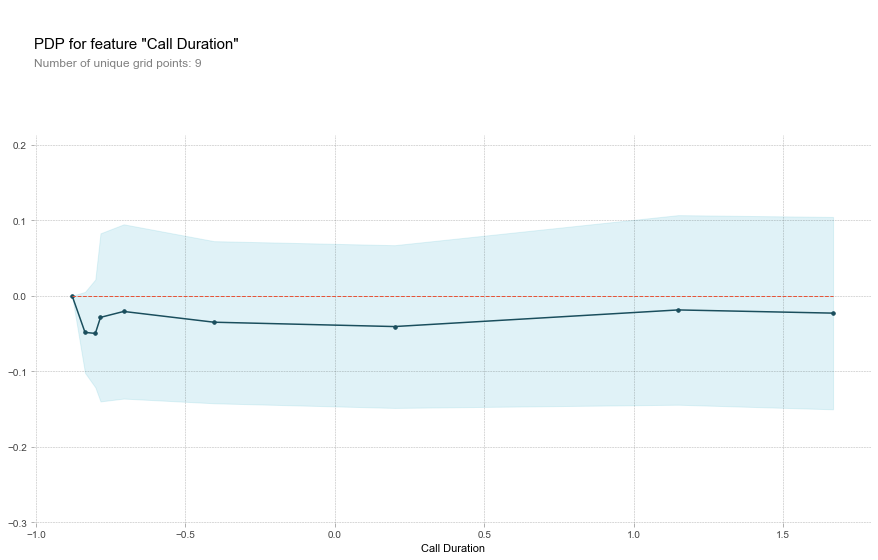

In [30]:
# Based on the testing data.
df_columns = data_df.columns
new_df_supervised = pd.DataFrame(test_data)
new_df_supervised.columns = df_columns

# Create plots for the top 3 features.
pdp_claim_value = pdp.pdp_isolate(model = rf_model, dataset = new_df_supervised, model_features = data_df.columns, 
                                    feature = 'Claim_Value')

pdp_purchased_from = pdp.pdp_isolate(model = rf_model, dataset = new_df_supervised, model_features = data_df.columns, 
                                    feature = 'Purchased_from_code')

pdp_call_details = pdp.pdp_isolate(model = rf_model, dataset = new_df_supervised, model_features = data_df.columns, 
                                    feature = 'Call_details')



# plot them.
pdp.pdp_plot(pdp_claim_value, 'Amount Claimed')
pdp.pdp_plot(pdp_purchased_from, 'Purchase Source')
pdp.pdp_plot(pdp_call_details, 'Call Duration')
plt.show()

### Neural Network (MLP) 

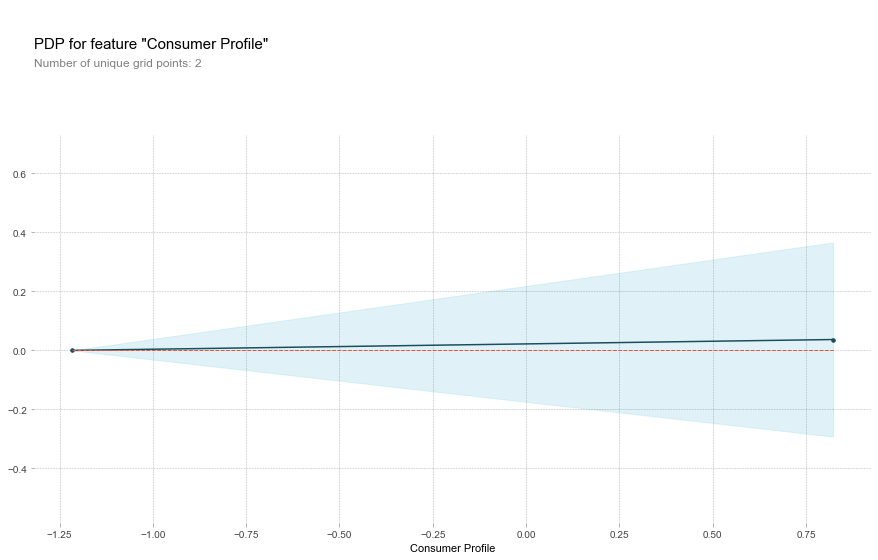

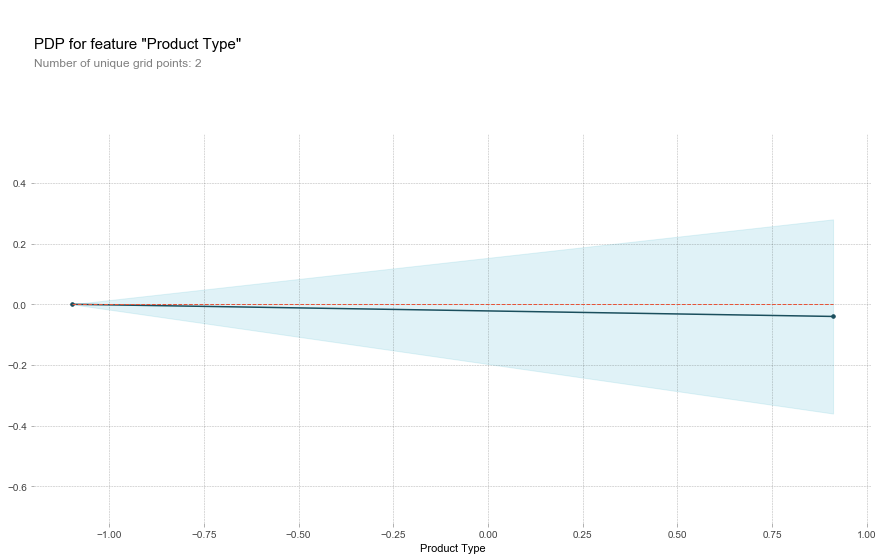

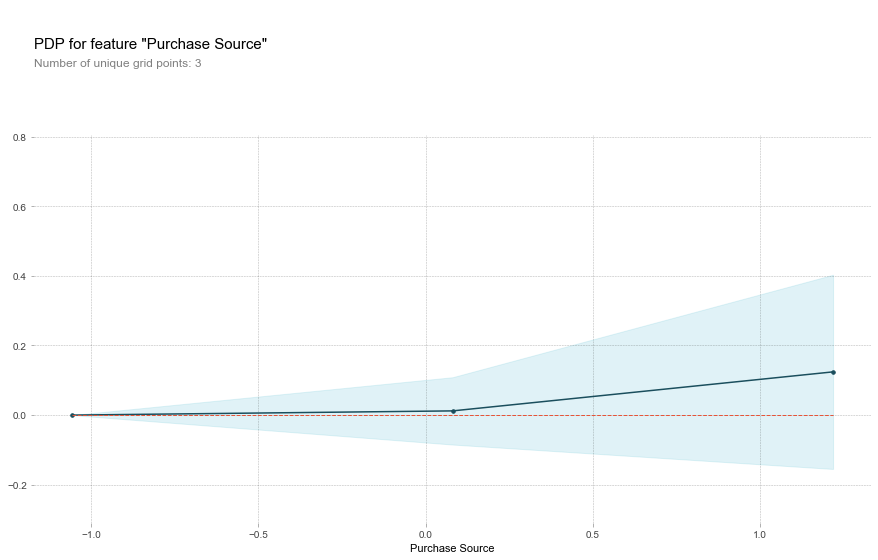

In [31]:
# Create plots for the top 3 features.
pdp_consumer_prof = pdp.pdp_isolate(model = nn_model, dataset = new_df_supervised, model_features = data_df.columns, 
                                    feature = 'Consumer_profile_code')

pdp_product_type = pdp.pdp_isolate(model = nn_model, dataset = new_df_supervised, model_features = data_df.columns, 
                                    feature = 'Product_type_code')

pdp_purchased_from = pdp.pdp_isolate(model = nn_model, dataset = new_df_supervised, model_features = data_df.columns, 
                                    feature = 'Purchased_from_code')

# plot them.
pdp.pdp_plot(pdp_consumer_prof, 'Consumer Profile')
pdp.pdp_plot(pdp_product_type, 'Product Type')
pdp.pdp_plot(pdp_purchased_from, 'Purchase Source')
plt.show()

## Visualise the Results 

- A graph will be shown for each algorithm to display each model's results.
- The data shown can be filtered with the use of sliders / dropdown menus.
- The graphs are multi-coordinated for easy comparisons.
- Certain attributes will be shown for a data point when the mouse hovers over it. 
- Each data point will be labelled based on the <b>true</b> labels.

<b>Note:</b> The most recent predictions of each model will be shown.

### Prepare the data 

- Creates a data frame for the unsupervised and supervised models.
- The unique ID is used to fetch the corresponding data records for the testing split.
- So the unsupervised graphs will show the whole data set, while the supervised graphs will show the testing data.

In [6]:
# Create a seperate dataframe for supervised algorithms.
supervised_df = pd.DataFrame()

for i in range(test_data_with_ID.shape[0]):
    matching_ID = warranty_df.loc[test_data_with_ID['Unique_ID'][i]]
    supervised_df = supervised_df.append(matching_ID)
#print(supervised_df.shape)

# Add model predictions to their respective dataframes.
warranty_df['KMeans_Predict'] = kmeans_pred
warranty_df['KNN_Predict'] = knn_pred
warranty_df['AE_Predict'] = ae_pred
supervised_df['RF_Predict'] = rf_pred
supervised_df['NN_Predict'] = nn_pred

# Include PCA reducted versions of both dataframes.
warranty_df['PCA_axis1'] = pca_unsupervised[:,0]
warranty_df['PCA_axis2'] = pca_unsupervised[:,1]
#print(pca_unsupervised[:,0])
supervised_df['PCA_axis1'] = pca_supervised[:,0]
supervised_df['PCA_axis2'] = pca_supervised[:,1]
#print(pca_supervised[:,0])

# Remove columns that aren't used. (Reduces lag on visualisation)
relavent_warranty_columns = ['KMeans_Predict', 'KNN_Predict', 'AE_Predict', 'Fraud', 'Product_type', 'Purpose', 
                               'Consumer_profile', 'Purchased_from', 'Claim_Value', 'Product_Age', 'Region', 
                             'Area', 'Call_details', 'PCA_axis1', 'PCA_axis2']
relavent_supervised_columns = ['RF_Predict', 'NN_Predict', 'Fraud', 'Product_type', 'Purpose', 
                               'Consumer_profile', 'Purchased_from', 'Claim_Value', 'Product_Age', 'Region', 
                               'Area', 'Call_details', 'PCA_axis1', 'PCA_axis2']
warranty_columns = [i for i in warranty_df.columns if (i in relavent_warranty_columns)]
supervised_columns = [i for i in supervised_df.columns if (i in relavent_supervised_columns)]

warranty_df = warranty_df[warranty_columns]
supervised_df = supervised_df[supervised_columns]

### Create the filters 

The data can be filtered by the following features:

- Region
- Consumer Profile
- Purchase Source
- Purpose
- Product Type
- Fraud (True Labels)
- <b> Dynamic axis have been included </b>
- <b> PCA axis option included </b>

In [9]:
# Elements for fraud dropdown filter.
fraud_dropdown = alt.binding_select(options = [0, 1], name = "Fraud: ")
fraud_select = alt.selection_single(fields = ['Fraud'], bind = fraud_dropdown)

# Elements for product type dropdown filter.
product_dropdown = alt.binding_select(options = list(warranty_df['Product_type'].unique()), name = "Product Type: ")
product_select = alt.selection_single(fields = ['Product_type'], bind = product_dropdown)

# Elements for purpose dropdown filter.
purpose_dropdown = alt.binding_select(options = list(warranty_df['Purpose'].unique()), name = "Purpose: ")
purpose_select = alt.selection_single(fields = ['Purpose'], bind = purpose_dropdown)

# Elements for customer profile dropdown filter.
consumer_prof_dropdown = alt.binding_select(options = list(warranty_df['Consumer_profile'].unique()), 
                                            name = "Consumer Profile: ")
consumer_prof_select = alt.selection_single(fields = ['Consumer_profile'], bind = consumer_prof_dropdown)

# Elements for purchased origin (from) dropdown filter.
purchased_dropdown = alt.binding_select(options = list(warranty_df['Purchased_from'].unique()), name = "Purchase Origin: ")
purchased_select = alt.selection_single(fields = ['Purchased_from'], bind = purchased_dropdown)

# Elements for region dropdown filter.
region_dropdown = alt.binding_select(options = list(warranty_df['Region'].unique()), name = "Region: ")
region_select = alt.selection_single(fields = ['Region'], bind = region_dropdown)

# Elements for area dropdown filter.
area_dropdown = alt.binding_select(options = list(warranty_df['Area'].unique()), name = "Area: ")
area_select = alt.selection_single(fields = ['Area'], bind = area_dropdown)

# Elements for the claim amount (Value) slider.
claim_amount_slider = alt.binding_range(min = warranty_df['Claim_Value'].min(), 
                                     max = warranty_df['Claim_Value'].max(), 
                                     step = 1000, 
                                     name = 'Amount Claimed (Indian Rupee):'
                                    )
select_claim_amount = alt.selection_single(fields = ['Claim_Value'], 
                                        bind = claim_amount_slider,
                                        init = {'Claim_Value': 0} 
                                       )

# For multi-coordinate zooming.
zoom = alt.selection_interval(bind = 'scales')

# Dropdown filters for selecting the axis' attributes.
columns = ['Claim_Value', 'Product_Age', 'Call_details', 'PCA_axis1', 'PCA_axis2']
select_box_column = alt.binding_select(options = columns, name = 'Column: ')
sel_col = alt.selection_single(fields = ['column'], bind = select_box_column, init = {'column': 'Claim_Value'})

rows = ['Claim_Value', 'Product_Age', 'Call_details', 'PCA_axis1', 'PCA_axis2']
select_box_row = alt.binding_select(options = rows, name = 'Row: ')
sel_row = alt.selection_single(fields = ['row'], bind = select_box_row, init = {'row': 'Product_Age'})

### Create each graph then display them 

In [10]:
# Set Global variables that all graphs will use.
circle_size = 50
graph_height = 230
graph_width = 230
# x_axis = alt.X('Product_Age:Q', scale = alt.Scale(zero = False))
# y_axis = alt.Y('Claim_Value:Q', scale = alt.Scale(zero = False))

# Remove row limit
alt.data_transformers.disable_max_rows()

#---------------Unsupervised Algorithms---------------
#----------KMeans Clustering Graph----------
kmeans_graph = alt.Chart(warranty_df).transform_fold(
    columns,
    as_=['column', 'Column']
).transform_fold(
    rows,
    as_=['row', 'Row']
).transform_filter(
    sel_col  
).transform_filter(
    sel_row  
).mark_point(filled = True).encode(
    x = 'Row:Q', 
    y = 'Column:Q',
    color = alt.Color('KMeans_Predict:O', 
                      title = 'Fraud', 
                      scale = alt.Scale(domain = [0, 1], 
                                        range = ['white', 'red'])
                     ),
    stroke = alt.value('black'),
    strokeWidth = alt.value(0.5),
    size = alt.value(circle_size),
    opacity = alt.value(1),
    tooltip = [alt.Tooltip('Purpose:N', title = 'Purpose'),
               alt.Tooltip('Claim_Value:Q', title = 'Claim Amount'),
               alt.Tooltip('Product_type:N', title = 'Product'),
               alt.Tooltip('Product_Age:Q', title = 'Product Age'),
               alt.Tooltip('KMeans_Predict:Q', title = 'Prediction'),
               alt.Tooltip('Fraud:Q', title = 'Actual')]
).properties(
    width = graph_width,
    height = graph_height,
    title = 'KMeans Clustering'
)

#----------K Nearest Neighbours Graph----------
knn_graph = alt.Chart(warranty_df).transform_fold(
    columns,
    as_=['column', 'Column']
).transform_fold(
    rows,
    as_=['row', 'Row']
).transform_filter(
    sel_col  
).transform_filter(
    sel_row  
).mark_point(filled = True).encode(
    x = 'Row:Q', 
    y = 'Column:Q',
    color = alt.Color('KNN_Predict:O', 
                      title = 'Fraud', 
                      scale = alt.Scale(domain = [0, 1], 
                                        range = ['white', 'red'])
                     ),
    stroke = alt.value('black'),
    strokeWidth = alt.value(0.5),
    size = alt.value(circle_size),
    opacity = alt.value(1),
    tooltip = [alt.Tooltip('Purpose:N', title = 'Purpose'),
               alt.Tooltip('Claim_Value:Q', title = 'Claim Amount'),
               alt.Tooltip('Product_type:N', title = 'Product'),
               alt.Tooltip('Product_Age:Q', title = 'Product Age'),
               alt.Tooltip('KNN_Predict:Q', title = 'Prediction'),
               alt.Tooltip('Fraud:Q', title = 'Actual')]
).properties(
    width = graph_width,
    height = graph_height,
    title = 'K-Nearest Neighbours'
)

#----------AutoEncoder Graph----------
ae_graph = alt.Chart(warranty_df).transform_fold(
    columns,
    as_=['column', 'Column']
).transform_fold(
    rows,
    as_=['row', 'Row']
).transform_filter(
    sel_col  
).transform_filter(
    sel_row  
).mark_point(filled = True).encode(
    x = 'Row:Q', 
    y = 'Column:Q',
    color = alt.Color('AE_Predict:O', 
                      title = 'Fraud', 
                      scale = alt.Scale(domain = [0, 1], 
                                        range = ['white', 'red'])
                     ),
    stroke = alt.value('black'),
    strokeWidth = alt.value(0.5),
    size = alt.value(circle_size),
    opacity = alt.value(1),
    tooltip = [alt.Tooltip('Purpose:N', title = 'Purpose'),
               alt.Tooltip('Claim_Value:Q', title = 'Claim Amount'),
               alt.Tooltip('Product_type:N', title = 'Product'),
               alt.Tooltip('Product_Age:Q', title = 'Product Age'),
               alt.Tooltip('AE_Predict:Q', title = 'Prediction'),
               alt.Tooltip('Fraud:Q', title = 'Actual')]
).properties(
    width = graph_width,
    height = graph_height,
    title = 'AutoEncoder'
)

#---------------Supervised Algorithms---------------
#----------Random Forest Graph----------
rf_graph = alt.Chart(supervised_df).transform_fold(
    columns,
    as_=['column', 'Column']
).transform_fold(
    rows,
    as_=['row', 'Row']
).transform_filter(
    sel_col  
).transform_filter(
    sel_row  
).mark_point(filled = True).encode(
    x = 'Row:Q', 
    y = 'Column:Q',
    color = alt.Color('RF_Predict:O', 
                      title = 'Fraud', 
                      scale = alt.Scale(domain = [0, 1], 
                                        range = ['white', 'red'])
                     ),
    stroke = alt.value('black'),
    strokeWidth = alt.value(0.5),
    size = alt.value(circle_size),
    opacity = alt.value(1),
    tooltip = [alt.Tooltip('Purpose:N', title = 'Purpose'),
               alt.Tooltip('Claim_Value:Q', title = 'Claim Amount'),
               alt.Tooltip('Product_type:N', title = 'Product'),
               alt.Tooltip('Product_Age:Q', title = 'Product Age'),
               alt.Tooltip('RF_Predict:Q', title = 'Prediction'),
               alt.Tooltip('Fraud:Q', title = 'Actual')]
).properties(
    width = graph_width,
    height = graph_height,
    title = 'Random Forest'
)

#----------Neural Network Graph----------
nn_graph = alt.Chart(supervised_df).transform_fold(
    columns,
    as_=['column', 'Column']
).transform_fold(
    rows,
    as_=['row', 'Row']
).transform_filter(
    sel_col  
).transform_filter(
    sel_row  
).mark_point(filled = True).encode(
    x = 'Row:Q', 
    y = 'Column:Q',
    color = alt.Color('NN_Predict:O', 
                      title = 'Fraud', 
                      scale = alt.Scale(domain = [0, 1], 
                                        range = ['white', 'red'])
                     ),
    stroke = alt.value('black'),
    strokeWidth = alt.value(0.5),
    size = alt.value(circle_size),
    opacity = alt.value(1),
    tooltip = [alt.Tooltip('Purpose:N', title = 'Purpose'),
               alt.Tooltip('Claim_Value:Q', title = 'Claim Amount'),
               alt.Tooltip('Product_type:N', title = 'Product'),
               alt.Tooltip('Product_Age:Q', title = 'Product Age'),
               alt.Tooltip('NN_Predict:Q', title = 'Prediction'),
               alt.Tooltip('Fraud:Q', title = 'Actual')]
).properties(
    width = graph_width,
    height = graph_height,
    title = 'Neural Network (MLP)'
)

# Combine each graph and apply filters.
(kmeans_graph | knn_graph | ae_graph).add_selection(fraud_select).transform_filter(fraud_select
).add_selection(product_select).transform_filter(product_select
).add_selection(purpose_select).transform_filter(purpose_select
).add_selection(purchased_select).transform_filter(purchased_select
).add_selection(consumer_prof_select).transform_filter(consumer_prof_select
).add_selection(area_select).transform_filter(area_select
).add_selection(region_select).transform_filter(region_select
).add_selection(select_claim_amount).transform_filter((select_claim_amount['Claim_Value'] <= datum['Claim_Value'])
).add_selection(
    zoom
).add_selection(
    sel_row
).add_selection(
    sel_col
) & (rf_graph | nn_graph).add_selection(fraud_select).transform_filter(fraud_select
).add_selection(product_select).transform_filter(product_select
).add_selection(purpose_select).transform_filter(purpose_select
).add_selection(purchased_select).transform_filter(purchased_select
).add_selection(consumer_prof_select).transform_filter(consumer_prof_select
).add_selection(area_select).transform_filter(area_select
).add_selection(region_select).transform_filter(region_select
).add_selection(select_claim_amount).transform_filter((select_claim_amount['Claim_Value'] <= datum['Claim_Value'])
).add_selection(
    zoom
).add_selection(
    sel_row
).add_selection(
    sel_col
)

alt.VConcatChart(...)